In [ ]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
import re
import pickle

## loading the trained attribute classifier and running it on whole lfw 

In [ ]:
def initialize_celeba(CELEBA_IMAGES = 30000):
    # global output_file_path, output_low_level_path, df_attributes
    attributes_path = "/content/drive/MyDrive/CelebA/metadata/list_attr_celeba.csv"
    df_attributes = pd.read_csv(attributes_path) 
    removeImages = df_attributes.shape[0] - CELEBA_IMAGES
    drop_indices = np.random.choice(df_attributes.index[1:], removeImages, replace=False)
    df_attributes = df_attributes.drop(drop_indices)     

    return df_attributes

In [ ]:
print(os.listdir("/content/drive/MyDrive/CelebA/zipped/img_align_celeba/img_align_celeba"))

KeyboardInterrupt: ignored

In [ ]:
class celebAData(Dataset):
    def __init__(self,df_attributes,transform=None,train=True):
        super().__init__()
        self.df_attributes = df_attributes
        self.transform = transform
        self.train = train
        self.data_list = df_attributes['image_id'].tolist()
        # celeba_id = df['image_id'].tolist()

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,item):
        # global output_file_path, output_low_level_path, df_attributes
        # print(item)
        img_idx = item
        imgname = self.data_list[item]
        # foldername = imgname[:-9]
        # imgpath = os.path.join('/content/drive/MyDrive/LFW/zipped/lfw',foldername,imgname)
        imgpath = os.path.join("/content/drive/MyDrive/CelebA/zipped/img_align_celeba/img_align_celeba", imgname)
        # print(imgpath)
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        imgr = cv2.resize(img,(224,224))
        label = self.df_attributes.iloc[img_idx][1:]
        label = np.array(label)
        label = np.where(label < 0,0,1)

        if self.transform is not None:
            imgr = self.transform(imgr)
        if self.train:
          return {
              'img' : imgr,
              'label' : torch.tensor(label)
          }
        else:
          return {
              'img':imgr
          }

df_attributes = initialize_celeba(30000)
attributesConsidered = 10
df_attributes_short = df_attributes.iloc[:, : attributesConsidered + 1]
print(df_attributes_short.shape)

dataset = celebAData(df_attributes_short)
tem = dataset.__getitem__(2)
plt.imshow(tem['img'])
print(tem["label"])

(30000, 41)
tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1])


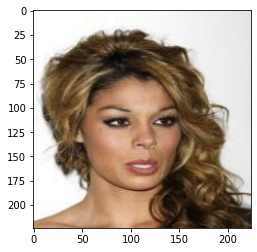

In [ ]:
df_attributes = initialize_celeba(30000)
attributesConsidered = 40
df_attributes_short = df_attributes.iloc[:, : attributesConsidered + 1]
print(df_attributes_short.shape)

dataset = celebAData(df_attributes_short)
tem = dataset.__getitem__(2)
plt.imshow(tem['img'])
print(tem["label"])

### using a dummy attribute just to use the previously made dataloader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6sg5MzE6FUgG2H7x9Z_ARHQ90Q1n2_VIwdxAD32bbQndfwmd6WyXU


In [ ]:
test_data = celebAData(df_attributes)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
len(test_data)

30000

## loading the model

In [ ]:
class ResnetModel(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
considered_attr = 40
attr_model = ResnetModel(considered_attr).to(device)
attr_model.load_state_dict(torch.load("/content/drive/MyDrive/project-sepnu/data/neural network/attr_net_75k_40.pth"))

In [ ]:
attr_model.eval()
from tqdm.notebook import tqdm
attr_preds = []
with torch.no_grad():
    for images in tqdm(test_loader):
        data = images['img'].squeeze(0).to(device)
        outputs = attr_model(data)
        pr = outputs.detach().cpu().numpy()
        for i in pr:
          attr_preds.append(np.round(i))  

In [ ]:
def get_resnet():
    model1 = models.resnet50(pretrained=True)
    for name, child in model1.named_children():
        for param in child.parameters():
            param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model1.fc.in_features
    model1.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, 36)
    )
    return model1
# model = model1.to(device)

In [ ]:
simile_model = get_resnet().to(device)
simile_model.load_state_dict(torch.load("/content/drive/MyDrive/project-sepnu/data/neural network/simile_model.pth"))

<All keys matched successfully>

In [ ]:
simile_model.eval()
from tqdm.notebook import tqdm
simile_preds = []
with torch.no_grad():
    for images in tqdm(test_loader):
        data = images['img'].squeeze(0).to(device)
        outputs = simile_model(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = outputs.detach().cpu().numpy()
        # print(pr)
        for i in pr:
          simile_preds.append(i) 



In [ ]:
with open("/content/drive/MyDrive/project-sepnu/data/neural network/simile_prediction.pkl","wb") as f:
    pickle.dump(simile_preds,f)

In [ ]:
import pickle
with open("/content/drive/MyDrive/project-sepnu/data/neural network/attr_prediction.pkl","wb") as f:
    pickle.dump(attr_preds,f)

In [ ]:
with open("/content/drive/MyDrive/project-sepnu/data/neural network/attr_prediction.pkl","rb") as f:
    attr_preds = pickle.load(f)
with open("/content/drive/MyDrive/project-sepnu/data/neural network/simile_prediction.pkl","rb") as f:
    simile_preds = pickle.load(f)

attr_preds = np.array(attr_preds)
simile_preds = np.array(simile_preds)
print(attr_preds.shape)
print(simile_preds.shape)
print(combined_preds.shape)
attr_preds_round = np.round(attr_preds)
# np.unique(attr_preds)
simile_preds_round = []
for i in range(simile_preds.shape[0]):
    fe = simile_preds[i]
    idx = np.argmax(fe)
    te = np.zeros(fe.shape)
    te[idx] = 1
    # print(fe)
    # print(te)
    simile_preds_round.append(te)
    # print(te)
# print(simile_preds[])
combined_preds = np.concatenate((attr_preds,simile_preds),axis=1)
combined_preds = np.concatenate((attr_preds_round,simile_preds_round),axis=1)

# print(combined_preds)
# print(attr_preds[0])
# print(attr_preds_round[0])


(13014, 40)
(13014, 36)
(13014, 76)


In [ ]:
# pairindexes contains a list containing a bunch of [index1, index2]
def genPairIndexes_lfw(attrPath = '/content/drive/MyDrive/LFW/metadata/modified_attributes.txt', genLabels = 0):
    global df_attributes
    df_attributes = pd.read_csv(attrPath, delimiter = ",")
    output_low_level_path = '/content/drive/MyDrive/project-sepnu/data/low level/lfw/'
    file_images_under_error = open(output_low_level_path + "images_under_error.txt", "r")
    while True:
        line = file_images_under_error.readline().replace("\n", "")
        if line == "": break
        line = line.split()[0]
        matched_pattern = re.match(r"^([\w-]+?)_(\d+).jpg$", line[line.rindex("/")+1:])
        name, image_num = matched_pattern.groups()
        name = name.replace("_", " ")
        image_num = int(image_num)
        initial_shape = df_attributes.shape
        df_attributes.drop(df_attributes[(df_attributes['person'] == name) & (df_attributes['imagenum'] == image_num)].index, inplace = True)
        final_shape = df_attributes.shape
        assert (final_shape[0] + 1, final_shape[1]) == initial_shape
    file_images_under_error.close()
    assert df_attributes.shape[0] == np.load(output_low_level_path + "rgb_chin.npy").shape[0]

    df = df_attributes
    lfwnames = df['person'].tolist()
    lfwnames_nums = df['imagenum'].tolist()
    lfwnames_act = []
    for i in range(len(lfwnames)):
        num = '{0:04}'.format(lfwnames_nums[i])
        lfwnames_act.append(lfwnames[i].replace(" ","_") + "_" + num + ".jpg")
    file_images_under_error = open(output_low_level_path + "images_under_error.txt", "r")

    with open("/content/drive/MyDrive/project-sepnu/src/verification /dataset.pkl", "rb") as input_file:
        datalist = pickle.load(input_file)

    pairIndexes = []
    labels = [] 
    err_names = {'dummy.jpg'}
    for first_person,second_person,label in datalist:
        first_person = first_person.split("/")[2]
        second_person = second_person.split("/")[2]
        if first_person not in lfwnames_act :
            # print(first_person, "not in list")
            err_names.add(first_person)
        elif second_person not in lfwnames_act:
            # continue
            # print(second_person, "not in list")
            err_names.add(second_person)
        else:
            # print(lfwnames_act.index(first_person), lfwnames_act.index(second_person))
            pairIndexes.append([lfwnames_act.index(first_person), lfwnames_act.index(second_person)])
            if label == 0:
                labels.append(-1)
            else:
                labels.append(1)
    # for i in range(10):
    # print(err_names)
        # print(pairIndexes[i])
    if genLabels:
        return pairIndexes, err_names, labels
    else:
        return pairIndexes, err_names

In [ ]:
pairs,errdict,labels = genPairIndexes_lfw(genLabels=1)
len(pairs)

6143

In [ ]:
print(min(combined_preds[1]))

-24.064976


In [ ]:
final_dataset = []

for p1,p2 in pairs:
    feature = np.hstack((combined_preds[p1],combined_preds[p2]))
    final_dataset.append(feature)

final_dataset = np.array(final_dataset)
print(final_dataset.shape)
final_dataset_labels = []


for i in range(len(final_dataset)):
    feat_label = {}
    feat_label["img"] = torch.tensor(final_dataset[i])
    feat_label["label"] = torch.tensor(max(labels[i],0))
    final_dataset_labels.append(feat_label)

final_dataset_labels.__getitem__(2)


In [ ]:
# for feat in final_dataset_labels:
final_dataset.mean()

-3.5502694

In [ ]:
class VerifNet(nn.Module):
    def __init__(self, tot_inputs):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(tot_inputs, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )
    def forward(self, x):
        x = self.classifier(x)        
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = VerifNet(152).to(device)
xrand = torch.rand((32,152)).to(device)
print(xrand.shape)
y = model(xrand)
# print(xrand)
# print(y)

cuda:0
torch.Size([32, 152])


In [ ]:
from tqdm.notebook import tqdm
def train_test(data_list):
    # full_dataset = CustomData(transforms,train_path,trainimgs)
    print("=========================================================================================")
    print("=========================================================================================")
    full_dataset = data_list
    train_size = int(0.8 * len(full_dataset)) 
    test_size = len(full_dataset) - train_size

    batch = 128
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

    model = VerifNet(152).to(device)
    optimizer = optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss().to(device)
    num_epochs = 50
    valid_loss_min = np.Inf

    losses = {'train' : [] } 
    accuracies = {'train' : []} 
    dataloaders = {
        'train':train_loader,
        'test':test_loader
    }
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        model.train()
        # for phase in ['train']:

        curr_loss = 0.0
        curr_acc = 0

        for dinputs in dataloaders["train"]:
            # print(dinputs["img"].shape)
            inputs = dinputs["img"].to(device)
            labels = dinputs["label"].to(device)

            outputs = model(inputs.float())
            loss = error(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            curr_loss += loss.item() * inputs.size(0)
            curr_acc += torch.sum(preds == labels.data)

        curr_loss = curr_loss / len(dataloaders["train"].sampler)
        curr_acc = curr_acc.double() / len(dataloaders["train"].sampler)
        
        losses["train"].append(curr_loss)
        accuracies["train"].append(curr_acc)
        # if epoch == num_epochs - 1:
        print("train" + ":")
        print('loss = {:.4f}     accuracy = {:.4f}'.format(curr_loss,curr_acc))

        model.eval()
        test_loss = 0.0
        test_acc = 0
        for dinputs in dataloaders["test"]:
            inputs = dinputs["img"].to(device)
            labels = dinputs["label"].to(device)

            outputs = model(inputs.float())
            loss = error(outputs, labels)

            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * inputs.size(0)
            test_acc += torch.sum(preds == labels.data)

        test_loss = test_loss / len(dataloaders["test"].sampler)
        test_acc = test_acc.double() / len(dataloaders["test"].sampler)
        print("test" + ":")
        print("loss: {:.4f}     accuracy: {:.4f}".format(test_loss, test_acc))
    # torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/project-sepnu/data/neural network/verif_model.pth"))

    return losses,accuracies    

In [ ]:
loss,acc = train_test(final_dataset_labels)